# Classification With Convolutional Neural Network (MNIST Data)

## Import

In [2]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms as T

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader , random_split
import torch.backends.cudnn as cudnn

from torchmetrics import Accuracy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## MNIST Dataset

In [3]:
train_transform = T.Compose([T.RandomCrop(28 , padding=4),
                             T.ToTensor(),
                             T.Normalize(mean=0.1307,
                                         std=0.3081)])

test_transform = T.Compose([T.ToTensor(),
                            T.Normalize(mean=0.1307
                                        ,std=0.3081)])

In [ ]:
train_set = MNIST('./MNIST' , train=True , download=True , transform= train_transform)
test_set = MNIST('./MNIST' , train=False , download=True , transform= test_transform)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


In [ ]:
torch.FloatTensor(train_set.data/255.).std()

tensor(0.3081)

In [ ]:
torch.FloatTensor(train_set.data/255.).mean()

tensor(0.1307)

In [ ]:
train_set.data.shape

torch.Size([60000, 28, 28])

## DataLoader

In [ ]:
train_dataloader = DataLoader(train_set ,  batch_size= 64 , shuffle=True)

test_dataloader = DataLoader(test_set , batch_size= 32)

In [ ]:
x , y = next(iter(train_dataloader))
print(x.shape)
print(y.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Visualize

In [ ]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

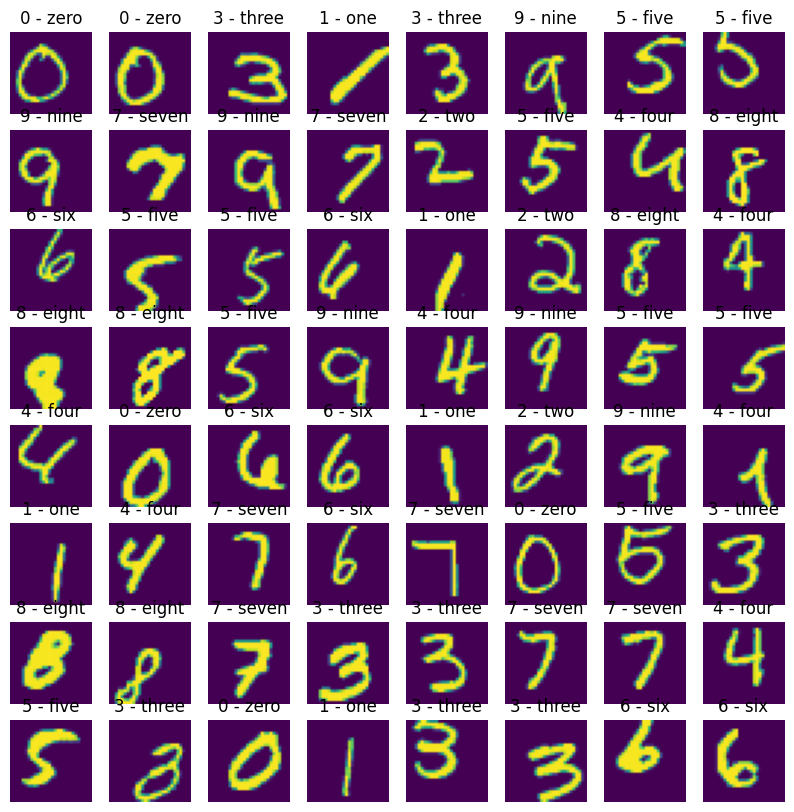

In [ ]:
batch = next(iter(train_dataloader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

## Model 

In [ ]:
def conv_bn_af(in_channels , out_channels , kernel_size , stride):
    module = nn.Sequential(nn.Conv2d(in_channels=in_channels , out_channels=out_channels ,  kernel_size=kernel_size , stride=stride , padding=1),
                           nn.BatchNorm2d(out_channels),
                           nn.ReLU())
    return module

In [ ]:
def CNN():
    network = nn.Sequential(conv_bn_af(1 , 32 , 3 , 2 ), #28x28
                            conv_bn_af(32 , 32 , 3 , 1),
                            conv_bn_af(32 , 64 , 1 , 1),
                            conv_bn_af(64 , 64 , 3 , 2),
                            conv_bn_af(64 , 128 , 1 , 1),
                            conv_bn_af(128 , 128 , 3 , 1),
                            conv_bn_af(128 , 128 , 3 , 2),
                            conv_bn_af(128 , 256 , 1 , 1),
                            conv_bn_af(256 , 256 , 3 , 1),
                            conv_bn_af(256 , 256 , 1 , 1),
                            conv_bn_af(256 , 256 , 3 , 1),
                            conv_bn_af(256 , 512 , 1 ,1),
                            conv_bn_af(512 , 512 , 3 , 1),
                            conv_bn_af(512 , 512 , 1 , 1),
                            conv_bn_af(512 , 512 , 3 , 2),
                            conv_bn_af(512 , 1024 , 1 , 1),
                            conv_bn_af(1024 , 1024 , 3 , 1),
                            conv_bn_af(1024 , 1024 , 1 , 1),
                            nn.AdaptiveAvgPool2d(output_size=(1 , 1)), #1x1

                            nn.Flatten(),
                            nn.Linear(1024 , 10) # classifier
                        )
    return network



In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Functions

In [ ]:
def train_one_epoch(model, train_dataloader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task="multiclass", num_classes=10).to(device)
  with tqdm(train_dataloader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_dataloader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task="multiclass", num_classes=10).to(device)
    for i, (inputs, targets) in enumerate(test_dataloader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

## Efficient Way For Set Hyperparams

### Check Forward Path

In [ ]:
x_batch, y_batch = next(iter(train_dataloader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(2.3327, device='cuda:0', grad_fn=<NllLossBackward0>)


### Check Backward Path

In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-1000, 1000))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 9: 100%|██████████| 50/50 [00:02<00:00, 18.01batch/s, accuracy=83.4, loss=0.591]


### Select Best Learning Rate

In [ ]:
num_epochs = 2
for lr in [0.1, 0.01 , 0.001 , 1e-4]:
  print(f'LR={lr}')
  model = CNN().to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_dataloader, loss_fn, optimizer, epoch)
  print()

LR=0.1


Epoch 1: 100%|██████████| 938/938 [02:19<00:00,  6.72batch/s, accuracy=97.8, loss=0.0723]



LR=0.01


Epoch 1: 100%|██████████| 938/938 [02:21<00:00,  6.65batch/s, accuracy=96.9, loss=0.112]



LR=0.001


Epoch 1: 100%|██████████| 938/938 [02:19<00:00,  6.71batch/s, accuracy=36.6, loss=1.77]



LR=0.0001


Epoch 1: 100%|██████████| 938/938 [02:20<00:00,  6.65batch/s, accuracy=18.6, loss=2.28]

### Small Grid

In [ ]:
epochs = 4
for lr in [0.05 , 0.1 , 0.15]:
  for wd in [0 , 1e-4 , 1e-5]:
    print(f'LR={lr} , WD={wd}')
    model = CNN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    for epoch in range(epochs):
      model, _, _ = train_one_epoch(model, train_dataloader, loss_fn, optimizer, epoch)
    print()

LR=0.05 , WD=0


Epoch 3: 100%|██████████| 938/938 [02:18<00:00,  6.76batch/s, accuracy=98.7, loss=0.0432]



LR=0.05 , WD=0.0001


Epoch 3: 100%|██████████| 938/938 [02:19<00:00,  6.70batch/s, accuracy=98.7, loss=0.0419]



LR=0.05 , WD=1e-05


Epoch 3: 100%|██████████| 938/938 [02:19<00:00,  6.73batch/s, accuracy=98.7, loss=0.0412]



LR=0.1 , WD=0


Epoch 3: 100%|██████████| 938/938 [02:17<00:00,  6.80batch/s, accuracy=98.7, loss=0.043]



LR=0.1 , WD=0.0001


Epoch 3: 100%|██████████| 938/938 [02:18<00:00,  6.76batch/s, accuracy=98.8, loss=0.0414]



LR=0.1 , WD=1e-05


Epoch 3: 100%|██████████| 938/938 [02:19<00:00,  6.75batch/s, accuracy=98.7, loss=0.0431]



LR=0.15 , WD=0


Epoch 3: 100%|██████████| 938/938 [02:17<00:00,  6.81batch/s, accuracy=98.8, loss=0.0415]



LR=0.15 , WD=0.0001


Epoch 3: 100%|██████████| 938/938 [02:18<00:00,  6.76batch/s, accuracy=98.6, loss=0.0452]



LR=0.15 , WD=1e-05


Epoch 3: 100%|██████████| 938/938 [02:18<00:00,  6.77batch/s, accuracy=98.6, loss=0.0455]

## Train Model

In [ ]:
model = CNN().to(device)

In [ ]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
n_epochs = 10
for epoch in range(n_epochs):
  model, loss_train, acc_train = train_one_epoch(model, train_dataloader, loss_fn, optimizer, epoch)
  loss_valid, acc_valid = validation(model, test_dataloader, loss_fn)
  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

Epoch 0: 100%|██████████| 938/938 [02:20<00:00,  6.65batch/s, accuracy=90.8, loss=0.273]


Valid: Loss = 0.09043, Acc = 0.9733



Epoch 1: 100%|██████████| 938/938 [02:18<00:00,  6.76batch/s, accuracy=97.9, loss=0.0716]


Valid: Loss = 0.05414, Acc = 0.9825



Epoch 2: 100%|██████████| 938/938 [02:18<00:00,  6.78batch/s, accuracy=98.4, loss=0.0527]


Valid: Loss = 0.05889, Acc = 0.9817



Epoch 3: 100%|██████████| 938/938 [02:18<00:00,  6.77batch/s, accuracy=98.7, loss=0.0441]


Valid: Loss = 0.0886, Acc = 0.9719



Epoch 4: 100%|██████████| 938/938 [02:19<00:00,  6.75batch/s, accuracy=98.9, loss=0.0371]


Valid: Loss = 0.04488, Acc = 0.9849



Epoch 5: 100%|██████████| 938/938 [02:21<00:00,  6.62batch/s, accuracy=98.9, loss=0.0347]


Valid: Loss = 0.02655, Acc = 0.992



Epoch 6: 100%|██████████| 938/938 [02:18<00:00,  6.77batch/s, accuracy=99.1, loss=0.0305]


Valid: Loss = 0.02373, Acc = 0.9922



Epoch 7: 100%|██████████| 938/938 [02:18<00:00,  6.78batch/s, accuracy=99.1, loss=0.0285]


Valid: Loss = 0.03233, Acc = 0.989



Epoch 8: 100%|██████████| 938/938 [02:18<00:00,  6.77batch/s, accuracy=99.2, loss=0.0271]


Valid: Loss = 0.03448, Acc = 0.9884



Epoch 9: 100%|██████████| 938/938 [02:18<00:00,  6.77batch/s, accuracy=99.2, loss=0.0262]


Valid: Loss = 0.03079, Acc = 0.9903



## Visualize

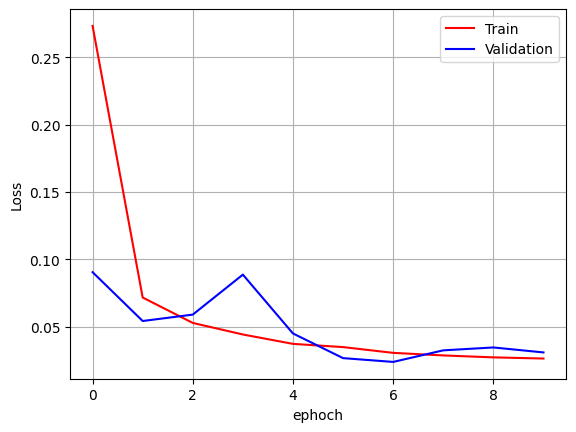

In [ ]:
plt.plot(range(n_epochs) , loss_train_hist , 'r-', label='Train')
plt.plot(range(n_epochs) , loss_valid_hist , 'b-', label='Validation')

plt.xlabel("ephoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

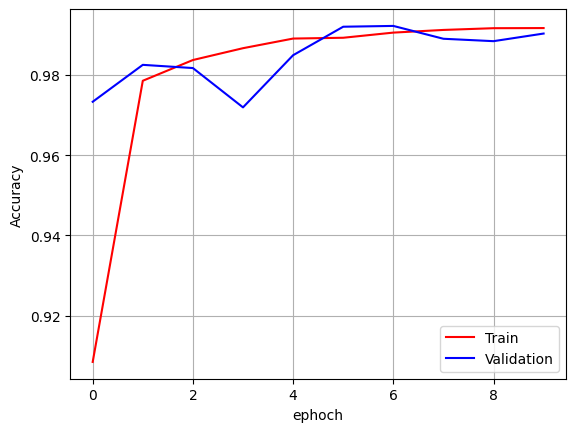

In [ ]:
plt.plot(range(n_epochs) , acc_train_hist , 'r-', label='Train')
plt.plot(range(n_epochs) , acc_valid_hist , 'b-', label='Validation')

plt.xlabel("ephoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()


## Test Model (Single Prediction)

In [ ]:
print(train_set.class_to_idx)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


True Label: 7
Predicted: 7, confidence=0.9912


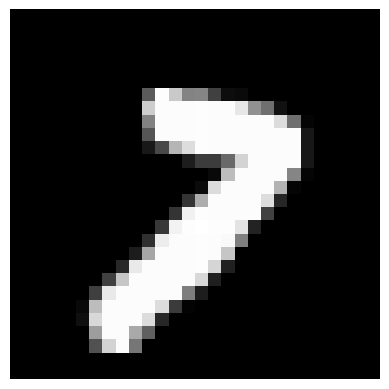

In [ ]:
import torch.nn.functional as F
import random


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("model.pt" , weights_only=False)
model.to(device)
model.eval()



idx = random.randint(0, len(test_set)-1)
img, true_label = test_set[idx]

img = img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img)
    probabilities = torch.softmax(output, dim=1)
    pred_idx = torch.argmax(probabilities, dim=1).item()
    confidence = probabilities[0,pred_idx].item()

print(f"True Label: {true_label}")
print(f"Predicted: {pred_idx}, confidence={confidence:.4f}")

plt.imshow(test_set.data[idx], cmap="gray")
plt.axis("off")
plt.show()